In [2]:
import mne
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import stats, signal
import itertools
import pandas as pd
from datetime import datetime
import os
from visbrain.io.rw_hypno import read_hypno
import yasa
from lspopt import spectrogram_lspopt
from matplotlib.colors import Normalize
from scipy import signal
import h5py
import joblib
import lightgbm


Extracting EDF parameters from C:\Lilach\402_for_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


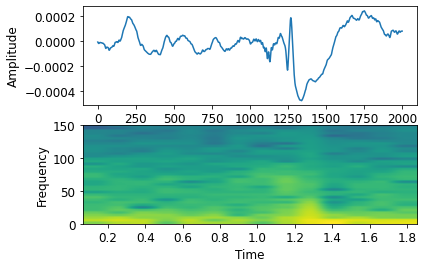

In [35]:
# get spike segment
sf = 1000
raw = mne.io.read_raw_edf('C:\\Lilach\\402_for_tag.edf')
spikes = raw.annotations
spikes_df = pd.DataFrame(spikes)
# end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
raw.crop(tmin=96, tmax=98).resample(sf)
signal_data = raw.copy().pick_channels(['RAH1']).get_data()[0]
# eye2_data = raw.copy().pick_channels(['EOG2']).get_data()[0]
# plt.plot(data)
# samplingFrequency, signalData = wavfile.read('y.wav')

# Plot the signal read from wav file
plt.subplot(211)

plt.plot(signal_data)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.subplot(212)
plt.specgram(signal_data,Fs=sf)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.ylim(0, 150)
plt.show() 

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0, 0.5, 'Log Power (dB / Hz)')

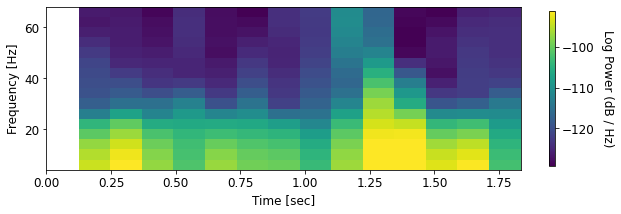

In [36]:
# yasa.plot_spectrogram(signal_data, sf, win_sec=0.5, cmap='Spectral_r')
data = signal_data
# Set default font size to 12
plt.rcParams.update({'font.size': 12})

# Calculate multi-taper spectrogram
nperseg = int(0.25 * sf)
assert data.size > 2 * nperseg, 'Data length must be at least 2 * win_sec.'
f, t, Sxx = spectrogram_lspopt(data, sf, nperseg=250, noverlap=128)
Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz

# Select only relevant frequencies (up to 30 Hz)
good_freqs = np.logical_and(f >= 0.1, f <= 70)
Sxx = Sxx[good_freqs, :]
f = f[good_freqs]
#     t /= 3600  # Convert t to hours

# Normalization
vmin, vmax = np.percentile(Sxx, [2.5, 97.5])
norm = Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
im = ax.pcolormesh(t, f, Sxx, norm=norm, antialiased=True)
# im = ax.pcolormesh(t, np.arange(0,41, 2), Sxx, norm=None, cmap=cmap, antialiased=True)
ax.set_xlim(0, t.max())
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')

# Add colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.95, fraction=0.1, aspect=25)
cbar.ax.set_ylabel('Log Power (dB / Hz)', rotation=270, labelpad=20)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


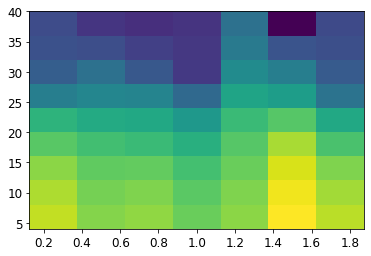

In [37]:
f, t, Sxx = spectrogram_lspopt(data, sf, nperseg=nperseg, noverlap=0)
Sxx = 10 * np.log10(Sxx)
good_freqs = np.logical_and(f >= 0.1, f <= 40)
Sxx = Sxx[good_freqs, :]
f = f[good_freqs]
plt.pcolormesh(t, f, Sxx)

In [108]:
np.arange(1,41)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [95]:
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet)
freqs = np.arange(5., 100., 3.)
n_cycles = freqs / 2.
power = tfr_array_morlet(data, sfreq=sf,
                         freqs=freqs, n_cycles=n_cycles,
                         output='avg_power')
# Baseline the output
# rescale(power, epochs.times, (0., 0.1), mode='mean', copy=False)
fig, ax = plt.subplots()
x, y = centers_to_edges(data.size * 1000, freqs)
mesh = ax.pcolormesh(x, y, power[0], cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_title('TFR calculated on a numpy array')
ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
fig.colorbar(mesh)
plt.tight_layout()

plt.show()

ValueError: epoch_data must be of shape (n_epochs, n_chans, n_times), got (1000,)

In [ ]:
%matplotlib qt
raw = mne.io.read_raw_edf('C:\\Lilach\\402_for_tag.edf')
raw.plot(duration=30, scalings='auto')

In [ ]:
for x in raw.annotations:
    print(x)

In [ ]:
# raw.annotations.save('C:\\Lilach\\402_anot.csv')

In [3]:
# Get tags from annotations (only until the 'end' cause it's 100% covered)
raw = mne.io.read_raw_edf('C:\\Lilach\\402_for_tag.edf')

df = pd.DataFrame(raw.annotations)
i = df.loc[df['description'] == 'END'].index[0]
df = df[:i]
right = df[df['description'].str.contains('Rt')]
left = df[df['description'].str.contains('Lt')]

Extracting EDF parameters from C:\Lilach\402_for_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [ ]:
path = 'C:\\Users\\user\\PycharmProjects\\pythonProject\\results\\'
subj = '402'
right_tags = pd.read_csv(path + f'{subj}\\{subj}_tags.csv')['R'].dropna()

In [21]:
# from mnelab.io.writers import write_edf
# for subj in ['396', '398', '402', '405', '406', '415', '416']:
#     raw = mne.io.read_raw_edf(f'C:\\Lilach\\{subj}_for_tag.edf')
#     raw.load_data()
#     raw.filter(l_freq=0.1, h_freq=500)
#     raw.notch_filter((60, 120, 180, 240), method='spectrum_fit')
#     write_edf(f'C:\\Lilach\\{subj}_for_tag_filtered.edf', raw)

In [ ]:
# create files with 100 samples
channel_name = 'LAH1'
#for subj in ['396', '398', '402', '406', '415', '416']:
for subj in ['396']:
    raw = mne.io.read_raw_fif(f'C:\\UCLA\\{subj}_cz+bi_full_filtered.fif')
    sf = raw.info['sfreq']
    path = f'C:\\analysis\\{subj}\\best_thresh_detect'
    pred_file = [x for x in os.listdir(path) if '2' not in x and 'tag' not in x][0]
    spikes_df = pd.read_csv(path + '\\' + pred_file)
    stim_amp, stim_grad, stim_env = np.zeros((1, raw.n_times)), np.zeros((1, raw.n_times)), np.zeros((1, raw.n_times))
    for evt in spikes_df.sample(100).values:
        if 'amp' in evt[1]:
            stim_amp[0][evt[4]] = 1
        if 'grad' in evt[1]:
            stim_grad[0][evt[4]] = 1
        if 'env' in evt[1]:
            stim_env[0][evt[4]] = 1

    raw.pick_channels([x for x in raw.ch_names if x[0] == 'L' and '-' not in x])
    info_amp = mne.create_info(['AMP'], raw.info['sfreq'], ['stim'])
    info_grad = mne.create_info(['GRAD'], raw.info['sfreq'], ['stim'])
    info_env = mne.create_info(['ENV'], raw.info['sfreq'], ['stim'])
    amp_raw = mne.io.RawArray(stim_amp, info_amp)
    grad_raw = mne.io.RawArray(stim_grad, info_grad)
    env_raw = mne.io.RawArray(stim_env, info_env)
    raw.load_data()
    raw.add_channels([amp_raw, grad_raw, env_raw], force_update_info=True)
    raw.save(f'C:\\analysis\\{subj}\\{subj}_LAH1_100_samples.fif', overwrite=True)


In [60]:
spikes_df.sample(100)

,Unnamed: 0,threshold_type,first_index,last_index,max_index,max_amp,duration,duration_sec
106,107,env,2029731,2029747,2029740,0.000321,16,0.0080
2577,2578,amp,46573247,46573283,46573269,0.001822,36,0.0180
1086,1087,"['env', 'grad']",18340520,18340597,18340565,-0.001534,77,0.0385
1384,1385,env,22667435,22667461,22667443,0.000183,26,0.0130
2712,2713,env,49215548,49215569,49215554,0.000214,21,0.0105
...,...,...,...,...,...,...,...,...
2333,2334,grad,41159214,41159248,41159214,-0.001426,34,0.0170
1549,1550,"['env', 'grad', 'amp']",27198741,27198813,27198782,0.001426,72,0.0360
2013,2014,"['env', 'grad']",36156248,36156272,36156264,0.000537,24,0.0120
953,954,"['env', 'grad']",16612243,16612395,16612374,-0.000901,152,0.0760


In [68]:
len(spikes_df[spikes_df['threshold_type'].str.contains(',')])

1339

In [ ]:
for subj in ['396', '398', '402', '406', '415', '416']:
    edf = f'C:\\UCLA\\P{subj}_overnightData.edf'
    raw = mne.io.read_raw_edf(edf)
    hypno_file = edf.split('_')[0] + '_hypno.txt'

    # read hypnogram old format (1sec)
    hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)

    # make raw object into epochs (30 sec)
    dummy_events = mne.make_fixed_length_events(raw, id=1, duration=30)[:len(hypno)]

    # incorporate the scoring into the events file:
    dummy_events[:, 2] = hypno
    event_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4, 'art': -1}

    # epoch data into 30sec pieces:
    epochs = mne.Epochs(raw, events=dummy_events, event_id=event_dict, tmin=0,
                        tmax=30, baseline=(0, 0), on_missing='ignore')
    epochs.drop(epochs['REM'].selection)
    nrem_raw = mne.io.RawArray(np.concatenate(epochs.get_data(), axis=1), raw.info)
    nrem_raw.save(edf.split('_')[0] + '_NREM.fif')

In [4]:
import mne
import pandas as pd
raw = mne.io.read_raw_edf("C:\\Lilach\\402_for_tag_filtered_fix_tag.edf")
raw.load_data()
raw_bi = raw.copy().pick_channels(['LAH1', 'LAH2']).load_data()
inst, ref_data = mne.set_eeg_reference(raw_bi, ['LAH2'])
bi = mne.set_bipolar_reference(raw_bi, anode=['LAH1'], cathode=['LAH2'], ch_name='bi').get_data()
data, sf, chan = raw.get_data(), raw.info['sfreq'], raw.info['ch_names']
pd.DataFrame({'sub':data[15]-data[16], 'LAH1-LAH2':data[28], 'ref': inst.get_data()[0], 'bi': bi[0]})

Extracting EDF parameters from C:\Lilach\402_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1921999  =      0.000 ...   961.000 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1922000
    Range : 0 ... 1921999 =      0.000 ...   961.000 secs
Ready.
Added the following bipolar channels:
bi


,sub,LAH1-LAH2,ref,bi
0,1.525902e-07,7.629511e-08,1.525902e-07,1.525902e-07
1,3.051804e-07,2.288853e-07,3.051804e-07,3.051804e-07
2,4.577707e-07,5.340658e-07,4.577707e-07,4.577707e-07
3,1.068132e-06,9.918364e-07,1.068132e-06,1.068132e-06
4,1.373312e-06,1.297017e-06,1.373312e-06,1.373312e-06
...,...,...,...,...
1921995,0.000000e+00,7.629511e-08,0.000000e+00,0.000000e+00
1921996,0.000000e+00,7.629511e-08,0.000000e+00,0.000000e+00
1921997,0.000000e+00,7.629511e-08,0.000000e+00,0.000000e+00
1921998,1.525902e-07,7.629511e-08,1.525902e-07,1.525902e-07


In [6]:
raw = mne.io.read_raw_edf("C:\\repos\\epileptic_activity\\bug_check_402.edf")
raw.load_data()
raw_bi = raw.copy().pick_channels(['LAH1', 'LAH2']).load_data()
inst, ref_data = mne.set_eeg_reference(raw_bi, ['LAH2'])
bi = mne.set_bipolar_reference(raw_bi, anode=['LAH1'], cathode=['LAH2'], ch_name='bi').get_data()
data, sf, chan = raw.get_data(), raw.info['sfreq'], raw.info['ch_names']
pd.DataFrame({'sub':data[15]-data[16], 'LAH1-LAH2':data[28], 'ref': inst.get_data()[0], 'bi': bi[0], 'LAH1': data[15], 'LAH2': data[16]})

Extracting EDF parameters from C:\repos\epileptic_activity\bug_check_402.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 239999  =      0.000 ...   959.996 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=240000
    Range : 0 ... 239999 =      0.000 ...   959.996 secs
Ready.
Added the following bipolar channels:
bi


,sub,LAH1-LAH2,ref,bi,LAH1,LAH2
0,0.000035,0.000035,0.000035,0.000035,3.135729e-05,-0.000004
1,0.000038,0.000038,0.000038,0.000038,2.769512e-05,-0.000010
2,0.000037,0.000037,0.000037,0.000037,1.548791e-05,-0.000021
3,0.000035,0.000035,0.000035,0.000035,2.975509e-06,-0.000032
4,0.000040,0.000040,0.000040,0.000040,2.288853e-07,-0.000039
...,...,...,...,...,...,...
239995,-0.000121,-0.000121,-0.000121,-0.000121,-1.334401e-04,-0.000012
239996,-0.000119,-0.000119,-0.000119,-0.000119,-1.329824e-04,-0.000014
239997,-0.000115,-0.000115,-0.000115,-0.000115,-1.357290e-04,-0.000020
239998,-0.000111,-0.000111,-0.000111,-0.000111,-1.432059e-04,-0.000032


In [9]:
import numpy as np
np.array_equal(bi[0], data[6]-data[7])

True

In [11]:
raw

<RawEDF | 402_for_tag_filtered_fix_tag.edf, 30 x 1922000 (961.0 s), ~439.9 MB, data loaded>

In [62]:
edf = 'C:\\Lilach\\%s_for_tag_filtered_fix_tag.edf'
sr = 1000
channels = ['RAH1', 'RA1']
epochs, epochs_random = [], []
window_size = int(sr / 4)
raw = mne.io.read_raw_edf(edf % '402')
spikes = raw.annotations
spikes_df = pd.DataFrame(spikes)
end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
spikes_df = spikes_df[spikes_df['description'].str.contains(channels[0][0] + 't')]
spikes_df = spikes_df.drop_duplicates(subset=['onset'])
complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]

# from first tags round- only some spikes here and there
random_spikes_df = spikes_df[spikes_df['onset'] > end_onset]
raw_data = raw.copy().pick_channels(channels).resample(sr).get_data()
for onset in random_spikes_df['onset']:
    epochs_random.append(raw_data[:, int(onset * sr - window_size / 2) : int (onset * sr + window_size / 2)].T)
y_windows_random = np.full(len(epochs_random), 1)

# from second tags round- complete data
raw_data = raw.crop(tmax=end_onset).pick_channels(channels).resample(sr).get_data()

for i in range(0, raw_data.shape[1], window_size):
    curr_block = raw_data[:, i: i  + window_size]
    if i + window_size < raw_data.shape[1]:
        epochs.append(curr_block.T)

y_windows = np.zeros(len(epochs))
for onset in complete_spikes_df['onset']:
    y_windows[int(onset * 1000 / window_size)] = 1

epochs = np.concatenate((epochs, epochs_random))
y_windows = np.concatenate((y_windows, y_windows_random))

Extracting EDF parameters from C:\Lilach\402_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [65]:
epochs.shape

(924, 250, 2)

In [ ]:
# deep preprocess
edf = '%s_for_tag_filtered_fix_tag.edf'
sr = 1000
channels = ['RAH1', 'RA1']
epochs, epochs_random = [], []
window_size = int(sr / 4)
raw = mne.io.read_raw_edf(edf % '402')
spikes = raw.annotations
spikes_df = pd.DataFrame(spikes)
end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
spikes_df = spikes_df[spikes_df['description'].str.contains(channels[0][0] + 't')]
spikes_df = spikes_df.drop_duplicates(subset=['onset'])
complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]

# from first tags round- only some spikes here and there
random_spikes_df = spikes_df[spikes_df['onset'] > end_onset]
raw_data = raw.copy().pick_channels(channels).resample(sr).get_data()
for onset in random_spikes_df['onset']:
    epochs_random.append(raw_data[:, int(onset * sr - window_size / 2) : int (onset * sr + window_size / 2)].T)
y_windows_random = np.full(len(epochs_random), 1)

# from second tags round- complete data
raw_data = raw.crop(tmax=end_onset).pick_channels(channels).resample(sr).get_data()

for i in range(0, raw_data.shape[1], window_size):
    curr_block = raw_data[:, i: i  + window_size]
    if i + window_size < raw_data.shape[1]:
        epochs.append(curr_block.T)

y_windows = np.zeros(len(epochs))
for onset in complete_spikes_df['onset']:
    y_windows[int(onset * 1000 / window_size)] = 1

epochs = np.concatenate((epochs, epochs_random))
y_windows = np.concatenate((y_windows, y_windows_random))

In [2]:
import h5py
import glob

# mat = scipy.io.loadmat()
subj = '486'
first_stim_sec = 3891
counter = '3'
# maya_path = 'C:\\Maya\\p486\\MACRO\\CSC2.mat'
# firas_path = f'C:\\Matlab\\D0{subj}_raw_v73_{counter}.mat'
mne_raw = None
subj_files_list = glob.glob(f'C:\\Maya\\p{subj}\\MACRO\\*')
for curr_file in subj_files_list:
    try:
        f = h5py.File(curr_file, 'r')
        data = f.get('data')
        data = np.array(data)
        # ch_names = mne.io.read_raw_edf('C:\\Matlab\\D037_04_02_21b.edf').info['ch_names']
        # ch_names = pd.read_csv(f'C:\\Matlab\\D{subj}_chans.csv', header=None)
        # ch_names = [x.replace('\'', '') for x in ch_names.iloc[:, 0].tolist()]
        # ch_names = [x for x in range(10)]
        ch_name_array = np.array([x for x in f['LocalHeader/origName']], dtype='uint16')
        ch_name = ''
        for x in ch_name_array:
            ch_name += chr(x[0])
        # sfreq = int(np.array(f.get('hdr/Fs'))[0][0])
        sfreq = np.array(f['LocalHeader/samplingRate'])[0][0]
        info = mne.create_info(ch_names=[ch_name], sfreq=sfreq)
        if mne_raw is None:
            mne_raw = mne.io.RawArray(data.T, info)
        else:
            mne_raw.add_channels([mne.io.RawArray(data.T, info)])
    except:
        print('error with' + curr_file)
        pass
# mne_raw.plot()
# scalp_chans = ['Pz', 'Fz', 'Cz']
# depth_chans = ['RH 01', 'RH 02', 'RA 01', 'ROF 01', 'RAC 02', 'LOF 01']
# mne_raw.pick_channels(scalp_chans + depth_chans)

# # zero phase prevent delay
# mne_raw.filter(l_freq=0.1, h_freq=250, picks=depth_chans, phase='zero-double')
# mne_raw.notch_filter((50, 100, 150, 200), picks=scalp_chans + depth_chans, method='spectrum_fit', phase='zero-double')
# mne_raw.filter(l_freq=0.1, h_freq=40, picks=scalp_chans, phase='zero-double')
# rotem_write_edf(mne_raw, f'P{subj}_full_filtered_{counter}.edf')

# mne_raw.load_data()
# save night
# mne_raw.save(f'C:\\Maya\\p{subj}\\P{subj}.fif')
# rotem_write_edf(mne_raw, f'C:\\Maya\\p{subj}\\P{subj}.edf')
# save for tag

Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
error withC:\Maya\p486\MACRO\CSC100.mat
error withC:\Maya\p486\MACRO\CSC101.mat
error withC:\Maya\p486\MACRO\CSC102.mat
error withC:\Maya\p486\MACRO\CSC103.mat
error withC:\Maya\p486\MACRO\CSC104.mat
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Rea

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_ti

In [3]:
mne_raw.reorder_channels(sorted(mne_raw.ch_names))


In [7]:
raw_debug = mne_raw.copy()

In [8]:
raw_debug.crop(tmin=first_stim_sec - 10, tmax=first_stim_sec + 180)


TypeError: expected str, bytes or os.PathLike object, not NoneType

<RawArray | 93 x 190001 (190.0 s), ~134.9 MB, data loaded>

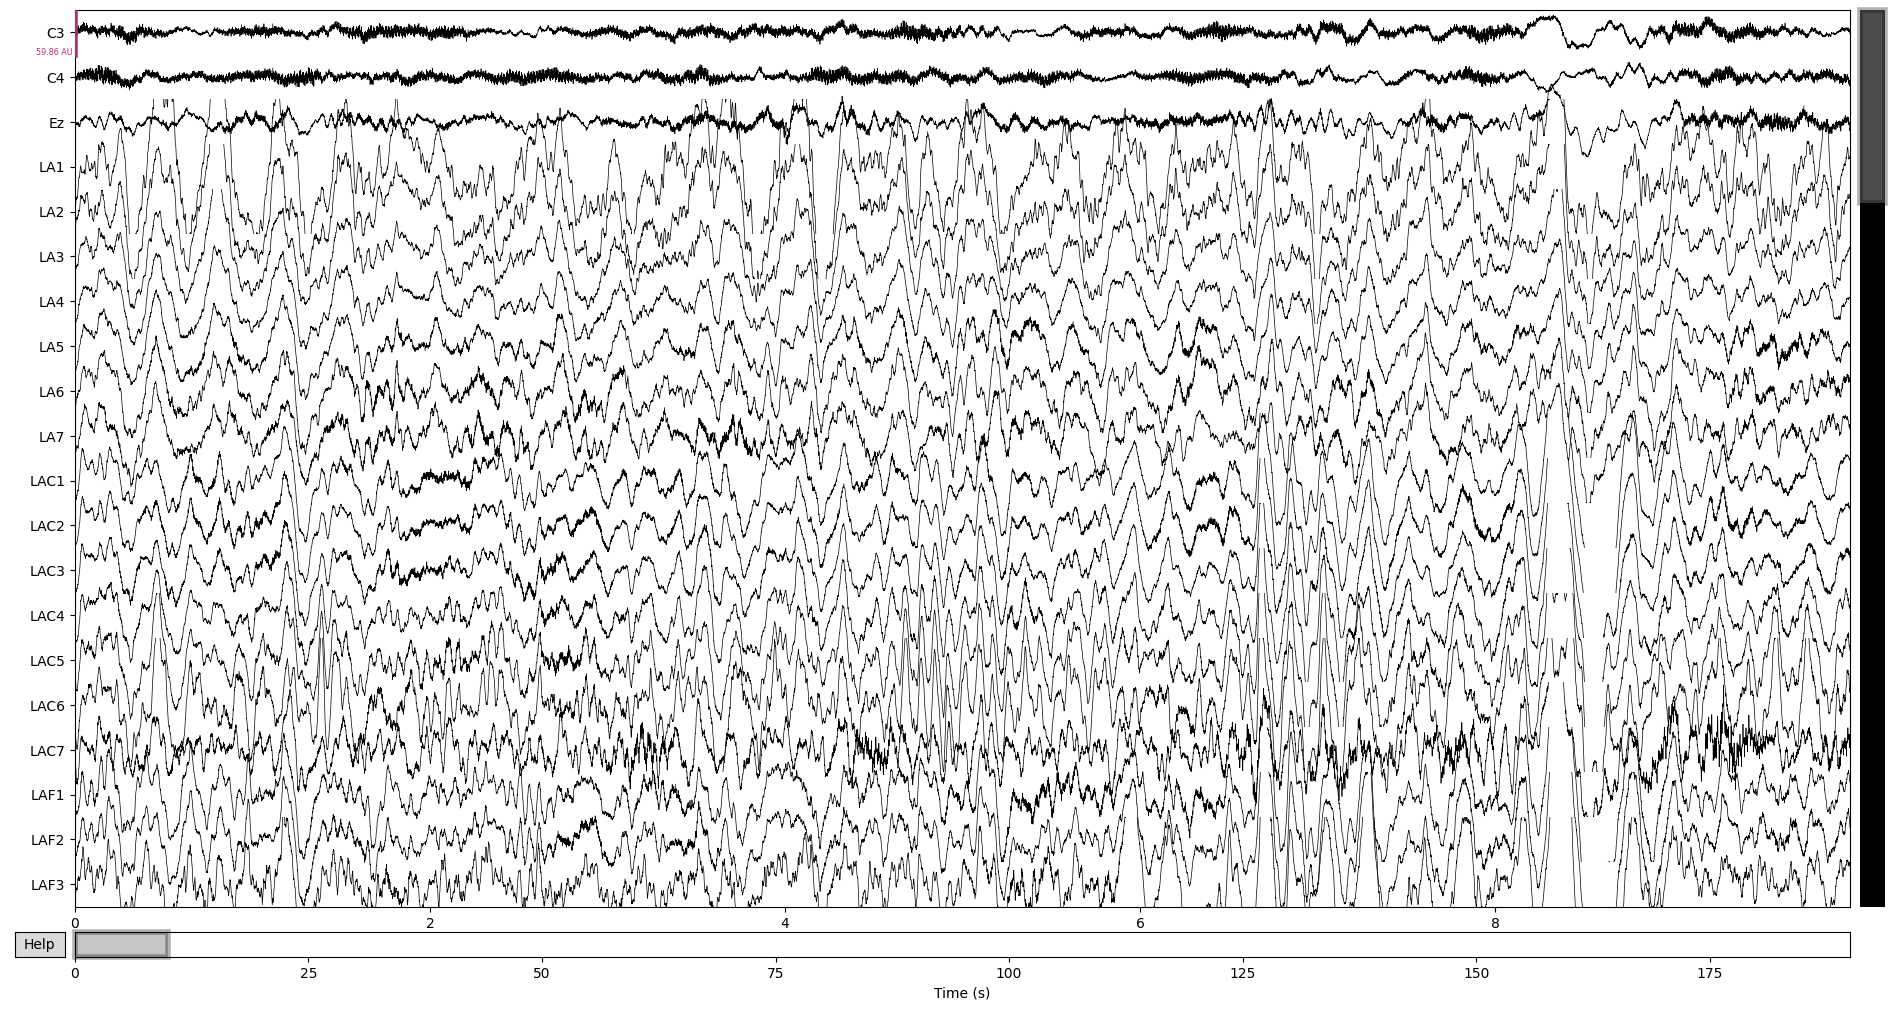

Channels marked as bad: none


In [9]:
%matplotlib qt
raw_debug.plot()

In [10]:
chan_data = raw_debug.pick_channels(['LEC7']).get_data()

In [ ]:
plt.plot(chan_data)

In [1]:
chan_data

NameError: name 'chan_data' is not defined

In [25]:
curr_file = 'C:\\Maya\\p485\\MACRO\\CSC1.mat'
# curr_file = 'C:\Maya\p486\MACRO\CSC52.mat'
f = h5py.File(curr_file, 'r')
data = f.get('data')
data = np.array(data)
p85 = data.T[0]

In [26]:
np.array(f['LocalHeader/samplingRate'])[0][0]

1000.0

In [11]:
data.T.shape

(1, 26051185)

In [15]:
lec7 = data.T[0]

In [27]:
np.min(p85)

nan

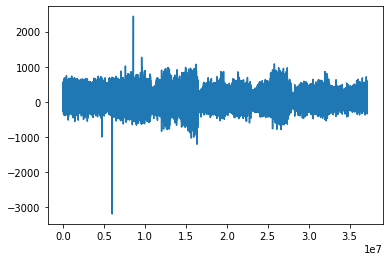

In [28]:
plt.plot(p85)

In [30]:
np.argwhere(np.isnan(p85)).shape


(55889, 1)

In [31]:
p85[np.isnan(p85)] = 0

In [32]:
np.argwhere(np.isnan(p85))


array([], shape=(0, 1), dtype=int64)

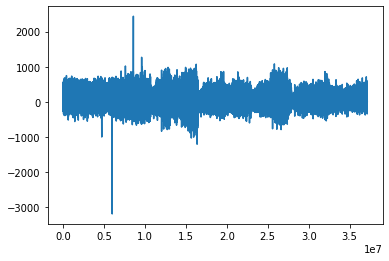

In [33]:
plt.plot(p85)

In [55]:
# counting spikes rates for thesis
edf = 'C:\\Lilach\\%s_for_tag_filtered_fix_tag.edf'
subj = '416'
sr = 1000
channels = ['RAH1', 'RA1']
epochs, epochs_random = [], []
window_size = int(sr / 4)
raw = mne.io.read_raw_edf(edf % subj)
spikes = raw.annotations
spikes_df = pd.DataFrame(spikes)
end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
# spikes_df = spikes_df[spikes_df['description'].str.contains(channels[0][0] + 't')]
# spikes_df = spikes_df.drop_duplicates(subset=['onset'])
complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]
#
# # from first tags round- only some spikes here and there
random_spikes_df = spikes_df[spikes_df['onset'] > end_onset]
# raw_data = raw.copy().pick_channels(channels).resample(sr).get_data()
# for onset in random_spikes_df['onset']:
#     epochs_random.append(raw_data[:, int(onset * sr - window_size / 2) : int (onset * sr + window_size / 2)].T)
# y_windows_random = np.full(len(epochs_random), 1)
#
# # from second tags round- complete data
# raw_data = raw.crop(tmax=end_onset).pick_channels(channels).resample(sr).get_data()
#
# for i in range(0, raw_data.shape[1], window_size):
#     curr_block = raw_data[:, i: i  + window_size]
#     if i + window_size < raw_data.shape[1]:
#         epochs.append(curr_block.T)
#
# y_windows = np.zeros(len(epochs))
# for onset in complete_spikes_df['onset']:
#     y_windows[int(onset * 1000 / window_size)] = 1

Extracting EDF parameters from C:\Lilach\416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [56]:
spikes_df

,onset,duration,description,orig_time
0,2.0000,0.0,Lt spike,2009-07-22 23:38:30+00:00
1,3.7512,0.0,Lt spike,2009-07-22 23:38:30+00:00
2,5.0870,0.0,Lt spike,2009-07-22 23:38:30+00:00
3,7.7952,0.0,Lt spike,2009-07-22 23:38:30+00:00
4,7.8684,0.0,Rt spike,2009-07-22 23:38:30+00:00
...,...,...,...,...
66,403.4695,0.0,Rt spike,2009-07-22 23:38:30+00:00
67,496.9863,0.0,Lt spike,2009-07-22 23:38:30+00:00
68,500.7375,0.0,Lt spike,2009-07-22 23:38:30+00:00
69,936.7786,0.0,Rt spike,2009-07-22 23:38:30+00:00


In [57]:
complete_spikes_df

,onset,duration,description,orig_time
0,2.0000,0.0,Lt spike,2009-07-22 23:38:30+00:00
1,3.7512,0.0,Lt spike,2009-07-22 23:38:30+00:00
2,5.0870,0.0,Lt spike,2009-07-22 23:38:30+00:00
3,7.7952,0.0,Lt spike,2009-07-22 23:38:30+00:00
4,7.8684,0.0,Rt spike,2009-07-22 23:38:30+00:00
...,...,...,...,...
58,183.5830,0.0,Rt spike,2009-07-22 23:38:30+00:00
59,193.3000,0.0,Lt spike,2009-07-22 23:38:30+00:00
60,194.2692,0.0,Rt spike,2009-07-22 23:38:30+00:00
61,195.9000,0.0,Rt spike,2009-07-22 23:38:30+00:00


In [61]:
complete_spikes_df[complete_spikes_df['description'].str.contains('Rt')]

,onset,duration,description,orig_time
4,7.8684,0.0,Rt spike,2009-07-22 23:38:30+00:00
5,9.4970,0.0,Rt spike,2009-07-22 23:38:30+00:00
7,10.1648,0.0,Rt spike,2009-07-22 23:38:30+00:00
8,11.5555,0.0,Rt spike,2009-07-22 23:38:30+00:00
10,12.4522,0.0,Rt spike,2009-07-22 23:38:30+00:00
15,19.1292,0.0,Rt spike,2009-07-22 23:38:30+00:00
16,20.1896,0.0,Rt spike,2009-07-22 23:38:30+00:00
18,22.1932,0.0,Rt spike,2009-07-22 23:38:30+00:00
22,25.4420,0.0,Rt spike,2009-07-22 23:38:30+00:00
23,25.4613,0.0,Rt spike,2009-07-22 23:38:30+00:00


In [1]:
from visbrain.io.rw_hypno import (read_hypno, oversample_hypno)

subj = '415'
hypno_file = 'D:\\UCLA\\P%s_hypno.txt' % subj
hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)
hypno

Hypnogram successfully loaded (D:\UCLA\P415_hypno.txt)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [9]:
54*60

3240

In [3]:
sf_hypno

1.0

In [6]:
new_hypno, x = read_hypno('C:\\Users\\user\\PycharmProjects\\pythonProject\\hypno_415.csv')

TypeError: object of type 'NoneType' has no len()

In [19]:
hypno_df

,Stage,Time
1,Wake,3247.447998
2,N1,4059.312012
3,N2,4630.624023
4,N3,4660.691895
5,N2,4901.244141
...,...,...
179,N1,26580.992188
180,N2,26731.339844
181,N1,26821.544922
182,N2,27603.339844


In [16]:

spikes_df

,3032
0,6366
1,6803
2,8111
3,13401
4,13620
...,...
814,109688
815,109819
816,109825
817,111201


In [7]:
# For thesis- spikes per stage
subj = '416'
filename = f'C:\\Users\\user\\PycharmProjects\\pythonProject\\hypno_{subj}.csv'
hypno_df = pd.read_csv(filename, delim_whitespace=True, header=None, names=['Stage', 'Time']).drop([0])
spikes_df = pd.read_csv(f'thesis_depth_lgbm_{subj}.csv')
spike_per_stage = {'Wake': 0, 'N1': 0, 'N2': 0, 'N3': 0, 'REM': 0}
for spike in spikes_df.values:
    spike_sec = spike[0] * 250 / 1000
    if len(hypno_df[hypno_df['Time'] < spike_sec]) == 0:
        spike_per_stage['Wake'] += 1
    else:
        stage_index = len(hypno_df[hypno_df['Time']< spike_sec])
        stage = hypno_df.iloc[stage_index]['Stage']
        spike_per_stage[stage] += 1
spike_per_stage

{'Wake': 382, 'N1': 2081, 'N2': 1196, 'N3': 545, 'REM': 15}

In [44]:
spike_sec

4059.75

In [46]:
len(hypno_df[hypno_df['Time']< spike_sec])

2

In [54]:
hypno_df.iloc[2]['Stage']

'N2'

In [4]:
random_mtrics = joblib.load('depth_shuffle.pkl')

In [6]:
precision_random = [x['precision'] for x in random_mtrics]
# recall_random = [x['recall'] for x in random_mtrics]
accuracy_random = [x['accuracy'] for x in random_mtrics]
f_random = [x['f_score'] for x in random_mtrics]

(0.0, 1.0)

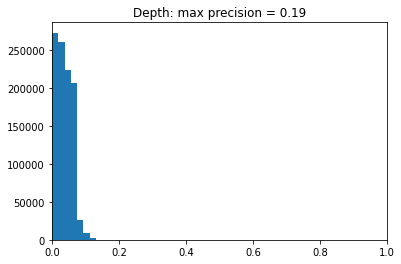

In [7]:
plt.hist(precision_random)
precision_max = '{0:.2f}'.format(max(precision_random))
plt.title('Depth: max precision = {}'.format(precision_max))
plt.xlim(0, 1)

Text(0.040209128985507235, 246443.715, 'Mean: 0.04')

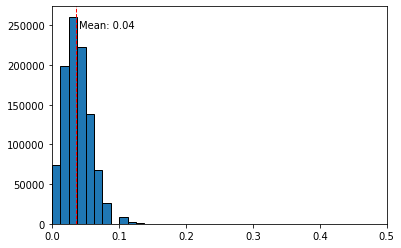

In [25]:
x = np.array(precision_random)
plt.hist(precision_random, bins=15, edgecolor="black")
plt.xlim(0, 0.5)
plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))

Text(0.5, 0, 'Precision')

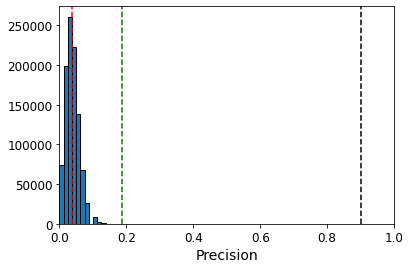

In [52]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'medium'})
x = np.array(precision_random)
plt.hist(precision_random, bins=15, edgecolor="black")
plt.xlim(0, 1)
plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(x.max(), color='green', linestyle='dashed', linewidth=1.5)
plt.axvline(0.9, color='black', linestyle='dashed', linewidth=1.5)
plt.xlabel('Precision', fontsize=14)

Text(0.7536231884057971, 191678.44499999998, 'classifier: 90.00%')

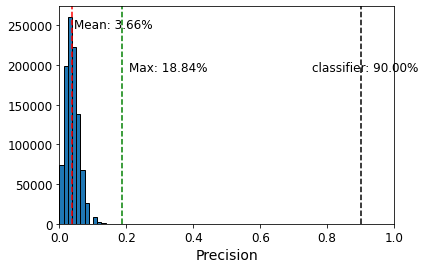

In [51]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'medium'})
x = np.array(precision_random)
plt.hist(precision_random, bins=15, edgecolor="black")
plt.xlim(0, 1)
plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(x.max(), color='green', linestyle='dashed', linewidth=1.5)
plt.axvline(0.9, color='black', linestyle='dashed', linewidth=1.5)
plt.xlabel('Precision', fontsize=14)

# min_ylim, max_ylim = plt.ylim()
# plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.2f}%'.format(x.mean() * 100))
# plt.text(x.max()*1.1, max_ylim*0.7, 'Max: {:.2f}%'.format(x.max() * 100))
# plt.text(x.max()*4, max_ylim*0.7, 'classifier: {:.2f}%'.format(90))

In [23]:
model = joblib.load('rf_fast.pkl')
imp_rf = pd.DataFrame(pd.read_csv('features_fast.csv').columns[1:])
imp_rf['imp'] = model.feature_importances_
imp_rf = imp_rf.sort_values(by=['imp'], ascending=False)
imp_rf.head(15)

,0,imp
11,abspow,0.066153
55,AH1-AH2_abspow,0.055727
27,abspow_cmin_norm,0.050486
70,AH1-AH2_abspow_cmin_norm,0.047265
44,AH1-AH2_std,0.045735
56,AH1-AH2_std_cmin_norm,0.044956
0,std,0.026831
72,AH1-AH2_std_pmin_norm,0.023710
12,std_cmin_norm,0.023088
42,abspow_pmin_norm,0.020901


<BarContainer object of 15 artists>

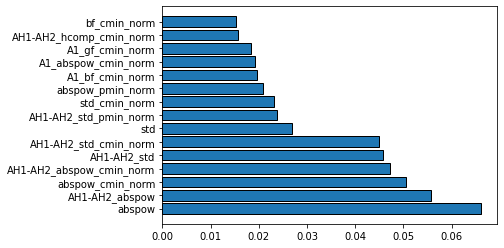

In [24]:
plt.barh(imp_rf.head(15).iloc[:, 0], imp_rf.head(15).iloc[:, 1], edgecolor="black")

In [25]:
model = joblib.load('lgbm_fast.pkl')
imp = pd.DataFrame(pd.read_csv('features_fast.csv').columns[1:])
imp['imp'] = model.feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

,0,imp
12,std_cmin_norm,89
0,std,75
60,AH1-AH2_hcomp_cmin_norm,74
3,kurt,65
17,hcomp_cmin_norm,62
55,AH1-AH2_abspow,60
47,AH1-AH2_kurt,54
72,AH1-AH2_std_pmin_norm,47
27,abspow_cmin_norm,46
46,AH1-AH2_skew,46


<BarContainer object of 15 artists>

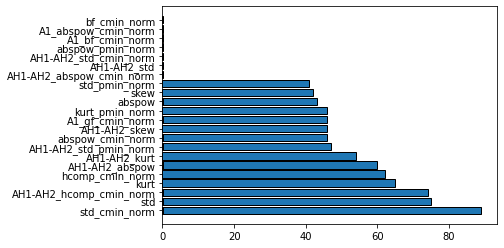

In [29]:
plt.barh(imp.head(15).iloc[:, 0], imp.head(15).iloc[:, 1], edgecolor="black")
plt.barh(imp_rf.head(15).iloc[:, 0], imp_rf.head(15).iloc[:, 1], edgecolor="black")

In [7]:
model_lgbm = joblib.load('thesis_scalp_lgbm.pkl')
imp = pd.DataFrame(model_lgbm.feature_name_)
imp['imp'] = model_lgbm.feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

,0,imp
66,gf_2,76
105,gf_pmin_norm_2,73
28,bf_cmin_norm,61
11,gf,58
10,bf,58
39,hcomp_pmin_norm,57
59,hcomp_2,57
9,sf,57
72,hcomp_cmin_norm_2,56
56,skew_2,54


In [9]:
model_rf = joblib.load('thesis_scalp_rf.pkl')
imp = pd.DataFrame(model_lgbm.feature_name_)
imp['imp'] = model_rf.feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

,0,imp
76,fast_cmin_norm_2,0.013413
56,skew_2,0.012090
65,bf_2,0.012027
85,abspow_cmin_norm_2,0.011617
59,hcomp_2,0.011527
82,sf_cmin_norm_2,0.011520
83,bf_cmin_norm_2,0.011331
28,bf_cmin_norm,0.011170
87,higuchi_cmin_norm_2,0.010908
27,sf_cmin_norm,0.010904


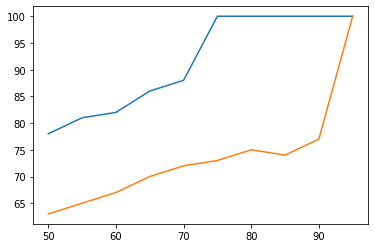

In [8]:
x_ticks = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
y_rf = [78, 81 ,82 ,86, 88 ,100 ,100 , 100, 100, 100]
y_lgbm = [63, 65, 67, 70, 72, 73, 75, 74, 77, 100]
plt.plot(x_ticks, y_rf)
plt.plot(x_ticks, y_lgbm)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


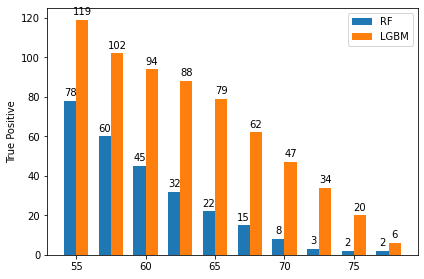

In [27]:
labels = x_ticks
tp_rf = [78, 60, 45, 32, 22, 15, 8, 3, 2, 2]
tp_lgbm = [119, 102, 94, 88, 79, 62, 47, 34, 20, 6]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tp_rf, width, label='RF')
rects2 = ax.bar(x + width/2, tp_lgbm, width, label='LGBM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('True Positive')
ax.set_xticklabels(labels)
# ax.set_xticks(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
# ax.plot(x_ticks, y_rf)
# ax.plot(x_ticks, y_lgbm)

fig.tight_layout()

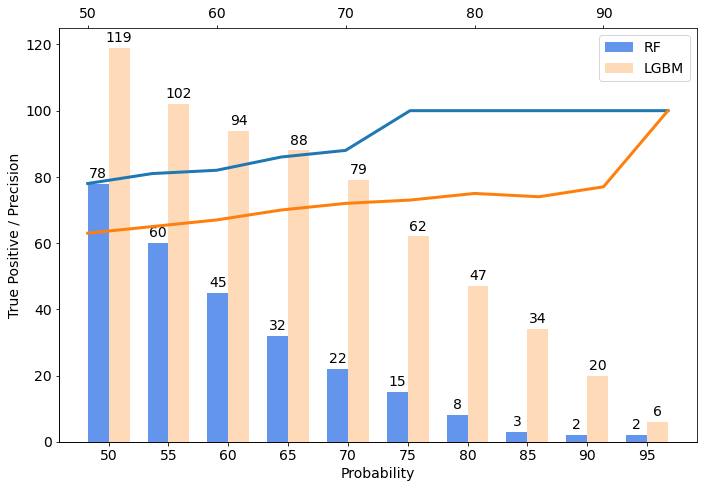

In [65]:
plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})
labels = x_ticks
tp_rf = [78, 60, 45, 32, 22, 15, 8, 3, 2, 2]
tp_lgbm = [119, 102, 94, 88, 79, 62, 47, 34, 20, 6]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, tp_rf, width, label='RF', color='cornflowerblue')
rects2 = ax.bar(x + width/2, tp_lgbm, width, label='LGBM', color='peachpuff')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('True Positive / Precision')
ax.set_xlabel('Probability')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
# ax.set_xticks(labels)
ax.legend()

ax2 = ax.twiny()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax2.plot(x_ticks, y_rf, linewidth=3)
ax2.plot(x_ticks, y_lgbm, linewidth=3)
# ax2.spines.right.set_visible(False)
# ax2.spines.top.set_visible(False)

fig.tight_layout()

In [17]:
labels

[50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [55]:
subj = '415'
hypno_file = 'D:\\UCLA\\P%s_hypno.txt' % subj
raw = mne.io.read_raw_edf('C:\\UCLA\\P%s_full_filtered.edf' % subj)
png_file_name = subj + '_C3_sbold.png'
raw = raw.pick_channels(['C3'])  # pick electrode for spectrogram
separate_NREM_power_spectrum = True  # set false if you want to see N2 and N3 together as NREM

Extracting EDF parameters from C:\UCLA\P415_full_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Hypnogram successfully loaded (D:\UCLA\P415_hypno.txt)
28-Sep-22 15:24:55 | INFO | Hypnogram successfully loaded (D:\UCLA\P415_hypno.txt)


Not setting metadata
926 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 926 events and 60001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


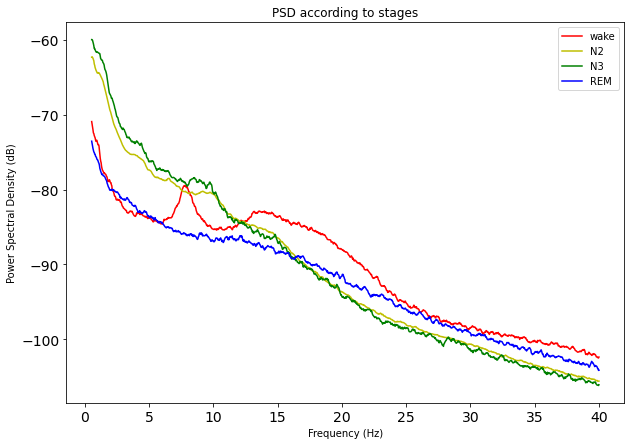

In [59]:
# read hypnogram old format (1sec)
hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)

# make raw object into epochs:
epoch_length = 30  # in seconds
event_id = 1  # This is used to identify the events.
dummy_events = mne.make_fixed_length_events(raw, id=event_id, duration=epoch_length)[:len(hypno)]
dummy_events[:, 2] = hypno  # HERE I TRIMMED THE END OF HYPNOGRAM BECAUSE OF THE DISCREPANCY
event_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4, 'art': -1}

# epoch data into 30sec pieces:
epochs = mne.Epochs(raw, events=dummy_events, event_id=event_dict, tmin=0,
                    tmax=30, baseline=(0, 0), on_missing='ignore')

data_out = raw.get_data()
# hypno_up = oversample_hypno(hypno, data_out.shape[1])

stage_spect_trls = [None] * len(event_dict)
stage_spect_avg = [None] * len(event_dict)
stage_spect_std = [None] * len(event_dict)
if separate_NREM_power_spectrum:
    stages_dict = {'W': 0, 'N2': 2, 'N3': 3, 'REM': 4}
else:
    stages_dict = {'W': 0, 'N2': 2, 'REM': 4}

epochs.load_data()
for ind, stage in enumerate(stages_dict):
    if epochs[stage].__len__() > 0:  # if not empty
        if separate_NREM_power_spectrum or stage != 'N2':
            psds, freqs = mne.time_frequency.psd_multitaper(epochs[stage], fmin=0.5, fmax=40, n_jobs=1)
        else:
            psds2, freqs2 = mne.time_frequency.psd_multitaper(epochs[stage], fmin=0.5, fmax=40, n_jobs=1)
            psds3, freqs3 = mne.time_frequency.psd_multitaper(epochs['N3'], fmin=0.5, fmax=40, n_jobs=1)
            psds = np.concatenate((psds2, psds3), axis=0)

        stage_spect_trls[ind] = psds

        psds_mean = psds.mean(0).mean(0)
        psd_db = 10. * np.log10(psds_mean)

        stage_spect_avg[ind] = psd_db

        psds_std = psds.mean(0).std(0)
        stage_spect_std[ind] = psds_std


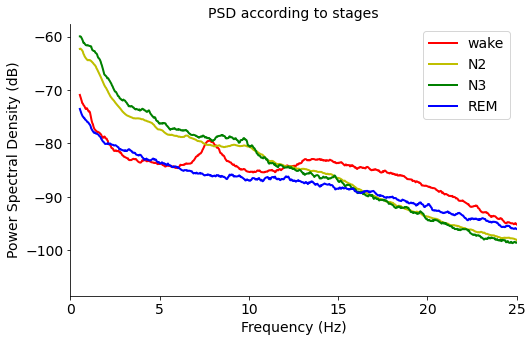

In [63]:
# plotting spectral figures:
stage_color = 'rygbk'
# stages_dict = {key: value for key, value in event_dict.items() if value >= 0}
# stages_dict = {'W': 0, 'N2': 2, 'REM': 4}
# ax2 = spectrogram_fig.add_subplot(gs[2, 0], aspect=0.8)
fig, ax = plt.subplots(figsize=(8, 5))
for i, stage in enumerate(stages_dict):  # runs on stages
    if stage_spect_avg[i] is not None:
        ax.plot(freqs, stage_spect_avg[i], color=stage_color[i], label=stage, linewidth=2)
        plt.fill_between(freqs, stage_spect_avg[i] - stage_spect_std[i], stage_spect_avg[i] + stage_spect_std[i],
                         color=stage_color[i], alpha=.2)


ax.set_title('PSD according to stages', fontsize='14')
ax.set_ylabel('Power Spectral Density (dB)', fontsize='14')
ax.set_xlabel('Frequency (Hz)', fontsize='14')
ax.legend(['wake', 'N2', 'N3', 'REM'] if separate_NREM_power_spectrum else ['wake', 'NREM', 'REM'],
           prop={'size': 14}, loc='upper right')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlim([0, 25])
plt.show()

Extracting EDF parameters from D:\Firas\D044\P44_full_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Opening raw-browser...


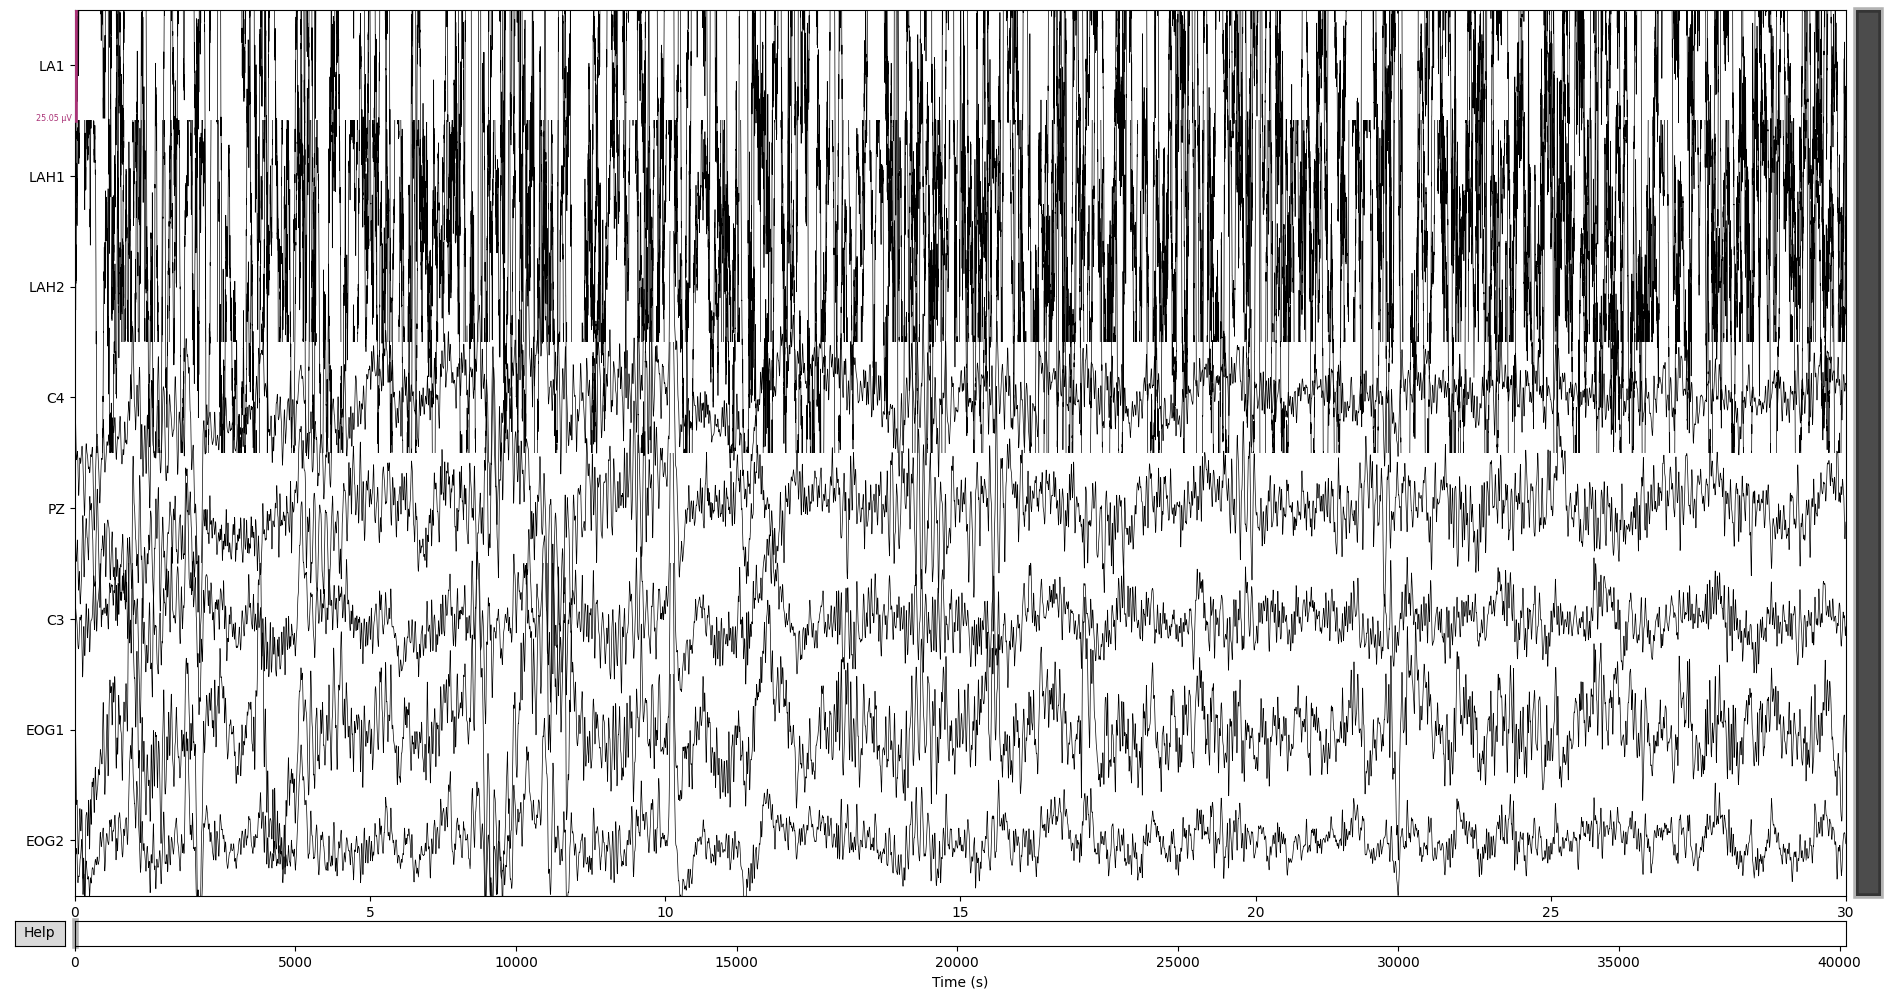

In [5]:
%matplotlib qt

subj= '44'
raw = mne.io.read_raw_edf(f'D:\\Firas\\D0{subj}\\P{subj}_full_filtered.edf')
raw.plot(duration=30, scalings='auto')

In [6]:
ah = raw.pick_channels(['LAH1']).get_data()[0]
ah

array([-6.01941863e-08,  1.82242069e-06,  2.33586111e-06, ...,
        3.36274195e-06,  1.65127388e-06,  2.82099428e-07])

In [22]:
ah_base = mne.baseline.rescale(ah, raw.times, (-1,1), copy=True)
ah_base

Applying baseline correction (mode: mean)


array([-5.80655528e-05, -5.61829380e-05, -5.56694976e-05, ...,
       -5.46426167e-05, -5.63540848e-05, -5.77232592e-05])

In [23]:
plt.plot(ah[:1500])
plt.plot(ah_base[:1500])

In [24]:
plt.plot(ah)
plt.plot(ah_base)

In [30]:
subj= '402'
path = 'C:\\Users\\user\\PycharmProjects\\pythonProject\\%s_clean.edf'
raw = mne.io.read_raw_edf(path % subj)
ah_402 = raw.pick_channels(['LAH1']).get_data()[0]
ah_base_402 = mne.baseline.rescale(ah_402, raw.times, (None,None), copy=True)
plt.plot(ah_402)
plt.plot(ah_base_402)

Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\402_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Applying baseline correction (mode: zscore)


In [29]:
ah_402.mean()

-4.937402651695879e-07

In [28]:
ah_base_402.mean()

-2.0405297993343658e-22

In [32]:
import glob
subjects = ['485', '486', '487', '488', '489', '496', '497']
frontal_stim = ['485', '486', '487', '488', '497', '498', '499', '505', '515', '541', '544', '545']
temporal_stim = ['489', '490', '496', '538']
for subj in subjects:
    subj_files_list = glob.glob(f'C:\\repos\\epileptic_activity\\results\\{subj}*rates*')
    rates_per_chan = {'channel': [], 'n_spikes': []}
    for i, curr_file in enumerate(subj_files_list):
        ch_name = curr_file.split(f'{subj}_')[1].split('_rates')[0]
        chan_rates = pd.read_csv(curr_file, index_col=0)
        rates_per_chan['channel'].append(ch_name)
        rates_per_chan['n_spikes'].append(chan_rates['n_spikes'].sum())

    df = pd.DataFrame(rates_per_chan)
    df.to_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_chan_sum.csv')
    top_10 = df.sort_values(by='n_spikes', ascending=False).iloc[:10, :]['channel'].tolist()
    blocks = []
    for chan in top_10:
        chan_rates = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_{chan}_rates.csv', index_col=0)
        y_axis = [chan_rates['rate'][0],  # the previous stop baseline
                  chan_rates['rate_1_20%'][1],
                  chan_rates['rate_2_20%'][1],
                  chan_rates['rate_3_20%'][1],
                  chan_rates['rate_4_20%'][1],
                  chan_rates['rate_5_20%'][1]]
        blocks.append(y_axis)

    avg_df = pd.DataFrame(blocks, columns=['0', '1', '2', '3', '4', '5'])
    means = [avg_df[str(i)].mean() for i in range(0, 6)]
    stds = [avg_df[str(i)].std() for i in range(0, 6)]
    plt.errorbar(list(range(0, 6)), means, yerr=stds, capsize=5, fmt='-o', label='avg', color='black')
    plt.title(f'{subj} - top 10')
    plt.xlabel('Time point')
    plt.ylabel('Spikes per minute')
    plt.savefig(f'C:\\repos\\epileptic_activity\\results\\{subj}_top_10.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [ ]:
# calc rate per chan and plot top ten
import glob
subjects = ['485', '486', '487', '488', '489', '496', '497']
frontal_stim = ['485', '486', '487', '488', '497', '498', '499', '505', '515', '541', '544', '545']
temporal_stim = ['489', '490', '496', '538']
for subj in subjects:
    subj_files_list = glob.glob(f'C:\\repos\\epileptic_activity\\results\\{subj}*rates*')
    rates_per_chan = {'channel': [], 'baseline': [], 'sum': []}
    for i, curr_file in enumerate(subj_files_list):
        ch_name = curr_file.split(f'{subj}_')[1].split('_rates')[0]
        chan_rates = pd.read_csv(curr_file, index_col=0)
        rates_per_chan['channel'].append(ch_name)
        rates_per_chan['baseline'].append(chan_rates['rate'][0])
        rates_per_chan['sum'].append(chan_rates['n_spikes'].sum())

    df = pd.DataFrame(rates_per_chan)
    df.to_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_chan_sum.csv')
    top_10 = df.sort_values(by='baseline', ascending=False).iloc[:10, :]['channel'].tolist()
    blocks = []
    for chan in top_10:
        chan_rates = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_{chan}_rates.csv', index_col=0)
        y_axis = [chan_rates['rate'][0],  # the previous stop baseline
                  chan_rates['rate_1_20%'][1],
                  chan_rates['rate_2_20%'][1],
                  chan_rates['rate_3_20%'][1],
                  chan_rates['rate_4_20%'][1],
                  chan_rates['rate_5_20%'][1]]
        blocks.append(y_axis)

    avg_df = pd.DataFrame(blocks, columns=['0', '1', '2', '3', '4', '5'])
    means = [avg_df[str(i)].mean() for i in range(0, 6)]
    stds = [avg_df[str(i)].std() for i in range(0, 6)]
    plt.errorbar(list(range(0, 6)), means, yerr=stds, capsize=5, fmt='-o', label='avg', color='black')
    plt.title(f'{subj} - top 10')
    plt.xlabel('Time point')
    plt.ylabel('Spikes per minute')
    plt.savefig(f'C:\\repos\\epileptic_activity\\results\\{subj}_top_10.png')
    plt.clf()

In [36]:
chan_rates['rate'][0]

18.133313185207573

In [37]:
frontal_stim = ['485', '486', '487', '488', '497', '498', '499', '505', '515', '541', '544', '545']
for subj in subjects:
    # subj_files_list = glob.glob(f'C:\\repos\\epileptic_activity\\results\\{subj}*rates*')
    # rates_per_chan = {'channel': [], 'baseline': [], 'sum': []}
    # for i, curr_file in enumerate(subj_files_list):
    #     ch_name = curr_file.split(f'{subj}_')[1].split('_rates')[0]
    #     chan_rates = pd.read_csv(curr_file, index_col=0)
    #     rates_per_chan['channel'].append(ch_name)
    #     rates_per_chan['baseline'].append(chan_rates['rate'][0])
    #     rates_per_chan['sum'].append(chan_rates['n_spikes'].sum())
    #
    # df = pd.DataFrame(rates_per_chan)
    df = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_chan_sum.csv')
    frontal_chans = df[df['channel'].str.contains('F')].tolist()
    blocks = []
    for chan in top_10:
        chan_rates = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_{chan}_rates.csv', index_col=0)
        y_axis = [chan_rates['rate'][0],  # the previous stop baseline
                  chan_rates['rate_1_20%'][1],
                  chan_rates['rate_2_20%'][1],
                  chan_rates['rate_3_20%'][1],
                  chan_rates['rate_4_20%'][1],
                  chan_rates['rate_5_20%'][1]]
        blocks.append(y_axis)

    avg_df = pd.DataFrame(blocks, columns=['0', '1', '2', '3', '4', '5'])
    means = [avg_df[str(i)].mean() for i in range(0, 6)]
    stds = [avg_df[str(i)].std() for i in range(0, 6)]
    plt.errorbar(list(range(0, 6)), means, yerr=stds, capsize=5, fmt='-o', label='avg', color='black')
    plt.title(f'{subj} - top 10')
    plt.xlabel('Time point')
    plt.ylabel('Spikes per minute')
    plt.savefig(f'C:\\repos\\epileptic_activity\\results\\{subj}_top_10.png')
    plt.clf()

{'channel': ['LA1',
  'LA2',
  'LA3',
  'LA4',
  'LA5',
  'LA6',
  'LAH1',
  'LAH2',
  'LAH3',
  'LAH4',
  'LAH5',
  'LAH6',
  'LAH7',
  'LEC1',
  'LEC2',
  'LEC3',
  'LEC4',
  'LEC5',
  'LEC6',
  'LEC7',
  'LOF1',
  'LOF2',
  'LOF3',
  'LOF4',
  'LOF5',
  'LOF6',
  'LOF7',
  'LPHG1',
  'LPHG2',
  'LPHG3',
  'LPHG4',
  'LPHG5',
  'LPHG6',
  'LPHG7',
  'RA1',
  'RA2',
  'RA3',
  'RA4',
  'RA5',
  'RA6',
  'REC1',
  'REC2',
  'REC3',
  'REC4',
  'REC5',
  'REC6',
  'RMH1',
  'RMH2',
  'RMH3',
  'RMH4',
  'RMH5',
  'RMH6',
  'RMH7',
  'ROF1',
  'ROF2',
  'ROF3',
  'ROF4',
  'ROF5',
  'ROF6',
  'ROF7',
  'RPHG1',
  'RPHG2',
  'RPHG3',
  'RPHG4',
  'RPHG5',
  'RPHG6',
  'RPHG7'],
 'n_spikes': [634.0,
  838.0,
  288.0,
  334.0,
  171.0,
  81.0,
  4075.0,
  2993.0,
  1964.0,
  396.0,
  95.0,
  128.0,
  196.0,
  2804.0,
  1999.0,
  2599.0,
  877.0,
  131.0,
  67.0,
  112.0,
  97.0,
  107.0,
  116.0,
  199.0,
  215.0,
  162.0,
  261.0,
  2447.0,
  2852.0,
  3529.0,
  1025.0,
  237.0,
  337.0,
 

In [44]:
frontal_stim = ['485', '486', '487', '488', '497', '498', '499', '505', '515', '541', '544', '545']
df = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{frontal_stim[3]}_chan_sum.csv')
df[~df['channel'].str.contains('F')]['channel'].tolist()

['C3',
 'LA1',
 'LA2',
 'LA3',
 'LA4',
 'LA5',
 'LA6',
 'LA7',
 'LPHG1',
 'LPHG2',
 'LPHG3',
 'LPHG4',
 'LPHG5',
 'LPHG6',
 'LPHG7',
 'RA1',
 'RA2',
 'RA3',
 'RA4',
 'RA5',
 'RA6',
 'REC1',
 'REC2',
 'REC3',
 'REC4',
 'REC5',
 'REC6',
 'REC7',
 'RPHG1',
 'RPHG2',
 'RPHG3',
 'RPHG4',
 'RPHG5',
 'RPHG6',
 'RPHG7',
 'RPP1',
 'RPP2',
 'RPP3',
 'RPP4',
 'RPP5',
 'RPP6',
 'RPP7',
 'RPS1',
 'RPS2',
 'RPS3',
 'RPS4',
 'RPS5',
 'RPS6',
 'RPS7',
 'RPT1',
 'RPT2',
 'RPT3',
 'RPT4',
 'RPT5',
 'RPT6']

In [1]:
from PIL import ImageFont, ImageDraw, Image
new_img_list= ['RAH', 'LAH']
new_img = Image.new("L", (1, len(new_img_list)), "white")
new_img.putdata(new_img_list)
new_img.save('out.tif')

In [2]:
import PIL, math
from PIL import ImageFont, ImageDraw, Image

text='RAH1, RAH2'

# Font and colour (best to use fixed-width font)
fnt="lucon.ttf"
textcol=(255,255,255)

# Create image of required dimensions
W,H=1000,1000
im=Image.new("RGB",(W,H))
draw=ImageDraw.Draw(im)

# Search for  font size which will fill image with text
nlett=len(text)
nx,ny=0,0
fsize=int(1.5*H)
while nx*ny<nlett:
    fsize=fsize-1
    font=ImageFont.truetype(fnt, fsize)
    # Just get size of one letter
    # In fixed-width fonts, all characters are the same size
    wint,hint = font.getsize("T")
    ny=math.floor(float(H)/float(hint))
    nx=math.floor(float(W)/float(wint))

dx=W-(nx*wint)
dy=H-(ny*hint)

# Pad out text so it is centred
x0=int(math.floor(float(dx)/2))
y0=int(math.floor(float(dy)/2))

# Draw text onto image
posx,posy=x0,y0
for letter in text:
    if(posx+wint)>W:
        posx=x0
        posy+=hint
    draw.text(xy=(posx,posy),text=letter,fill=textcol,font=font)
    posx+=wint

im.save("Text.png")
im.show()

In [27]:
import mne
edf_path = 'D:\\Maya\\p%s\\P%s_fixed.edf'
subj = '496'
raw = mne.io.read_raw_edf(edf_path % (subj, subj))

Extracting EDF parameters from D:\Maya\p496\P496_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [28]:
import pyprep
for_bad_channels = mne.pick_channels_regexp(raw.ch_names,'RTOP*')
print(for_bad_channels)
for_bad_raw = raw.pick_channels(raw.ch_names[30:61])
prep = pyprep.NoisyChannels(for_bad_raw)
# bad = ransac.find_bad_by_ransac(subj_raw.get_data(), sr, subj_raw.ch_names, [], [])
# Fit prep
# prep_params = {
#     "ref_chs": "eeg",
#     "reref_chs": "eeg",
#     "line_freqs": np.arange(60, sr / 2, 60),
# }
#
# prep = PrepPipeline(subj_raw.copy(), prep_params, mne.channels.make_standard_montage("standard_1005"))
# prep.fit()

[54, 55, 56, 57, 58, 59, 60, 61]
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:   24.3s finished


In [30]:
# prep.find_all_bads()
prep.get_bads()

['RMH6', 'RSO5']

In [20]:
raw.ch_names[for_bad_channels[0]: for_bad_channels[:-1]]

TypeError: slice indices must be integers or None or have an __index__ method

In [8]:
mne.pick_types(raw.info, eeg=True)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

Effective window size : 2.048 (s)


C:\Users\user\AppData\Local\Temp/ipykernel_15548/2852001142.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  subj_raw.plot_psd()


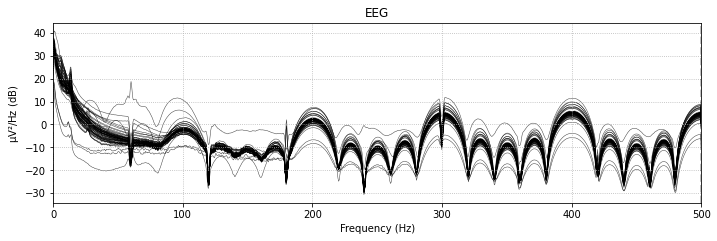

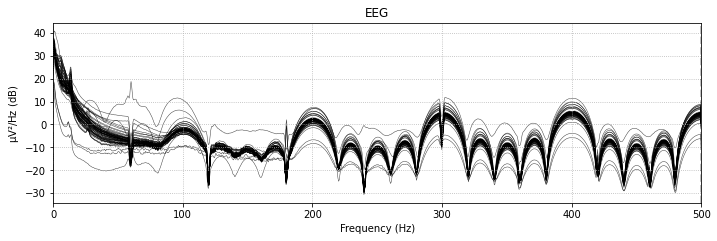

In [10]:
raw.plot_psd()

In [2]:
psd = raw.compute_psd()

Effective window size : 0.256 (s)


In [3]:
psd

Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Raw
Dims,"channel, freq"
Estimation method,welch
Number of channels,70
Number of frequency bins,129
Frequency range,0.00 – 500.00 Hz


In [4]:
psd[:2]

array([[4.91388454e-13, 3.86889271e-12, 1.34803007e-12, 8.33436585e-13,
        3.31447518e-13, 1.18163977e-13, 8.79232264e-14, 6.50626052e-14,
        5.69453326e-14, 5.58457155e-14, 5.43120789e-14, 5.47886230e-14,
        5.69734658e-14, 5.79976767e-14, 5.86558669e-14, 4.94435559e-14,
        5.49268893e-14, 6.02590863e-14, 5.99398892e-14, 5.82227163e-14,
        5.57791548e-14, 5.48002983e-14, 5.76839752e-14, 7.22064347e-14,
        9.23953180e-14, 1.11477984e-13, 1.15227790e-13, 1.02494811e-13,
        8.24009325e-14, 6.07889059e-14, 3.84799100e-14, 2.76862026e-14,
        4.19071055e-14, 4.59663054e-14, 4.14774440e-14, 3.71131533e-14,
        3.23076465e-14, 3.12557097e-14, 3.36136542e-14, 3.24006465e-14,
        2.77011985e-14, 2.55761894e-14, 2.82673266e-14, 3.01280823e-14,
        3.16217859e-14, 5.13356525e-14, 1.77022810e-13, 7.30788709e-14,
        6.24618623e-14, 1.17492766e-13, 1.80507991e-13, 2.19934722e-13,
        2.15296048e-13, 1.66773609e-13, 9.90729532e-14, 4.323352

C:\Users\user\AppData\Local\Temp/ipykernel_24792/561091968.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


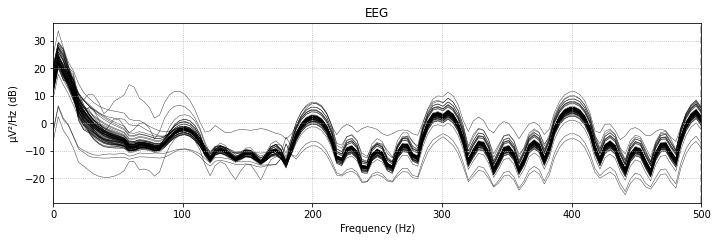

In [5]:
psd.plot()

In [6]:
'cC3'.upper()

'CC3'

Extracting EDF parameters from D:\Maya\p545\P545_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\user\AppData\Local\Temp/ipykernel_29332/1122570662.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=1, fmax=130)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


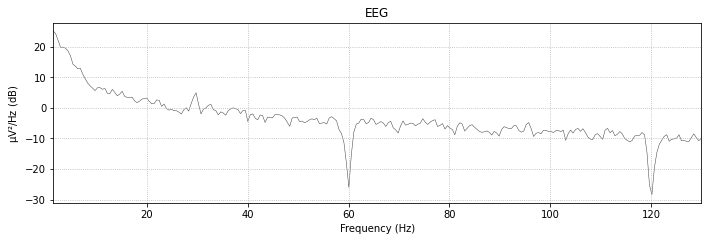

In [3]:
edf_path = 'D:\\Maya\\p%s\\P%s_fixed.edf'
subj = '545'
timing = [2, 14, 20, 24]
channels = ['ROF2']
raw = mne.io.read_raw_edf(edf_path % (subj, subj)).pick_channels(channels).crop(tmax=60)
raw.plot_psd(fmin=1, fmax=130)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\user\AppData\Local\Temp/ipykernel_29332/2936231884.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.copy().crop(tmin=i, tmax=i+2).plot_psd(fmin=1, fmax=120)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\user\AppData\Local\Temp/ipykernel_29332/2936231884.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.copy().crop(tmin=i, tmax=i+2).plot_psd(fmin=1, fmax=120)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\user\AppData\Local\Temp/ipykernel_29332/2936231884.py:2: Runtim

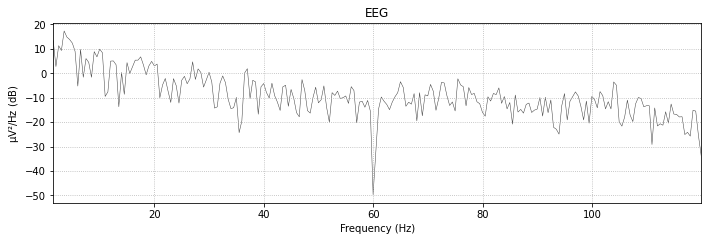

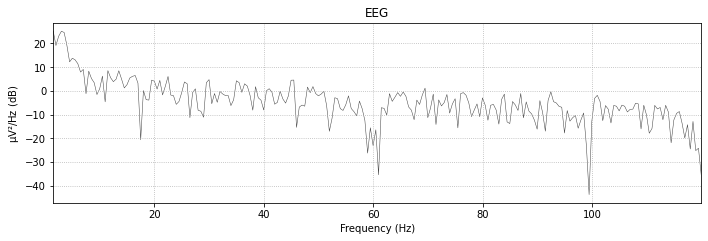

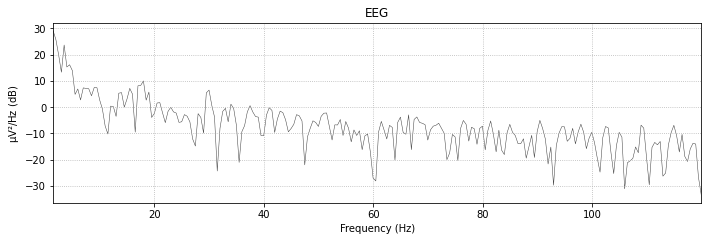

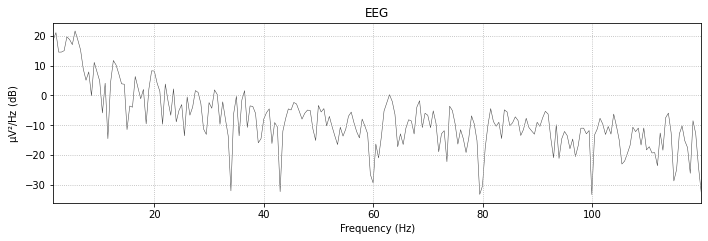

In [30]:
for i in timing:
    raw.copy().crop(tmin=i, tmax=i+2).plot_psd(fmin=1, fmax=120)

In [19]:
# for i in timing:
#     x = raw.copy().crop(tmin=i, tmax=i+2).compute_psd(fmin=1, fmax=120)
# x.get_data()
plt.plot(np.reshape(x.get_data()[0], (1,16)))

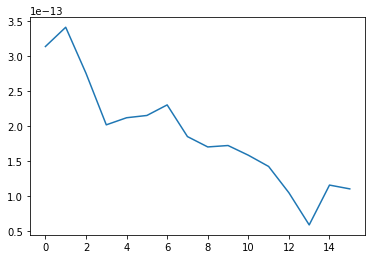

In [23]:
%matplotlib inline
y=list(x.get_data()[0])
y
plt.plot(y)

In [27]:
x = raw.copy().crop(tmin=2, tmax=4).compute_psd(fmin=1, fmax=120)
x

Effective window size : 0.256 (s)


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Raw
Dims,"channel, freq"
Estimation method,welch
Number of channels,1
Number of frequency bins,30
Frequency range,3.91 – 117.19 Hz


Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\user\AppData\Local\Temp/ipykernel_29332/3092415589.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  x.plot()
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


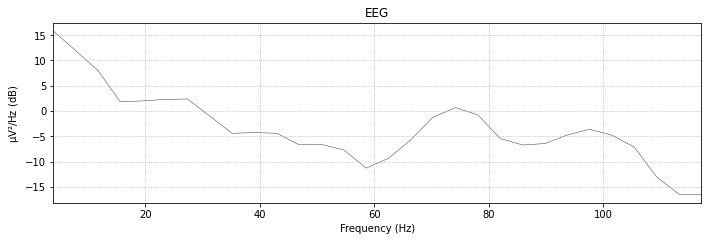

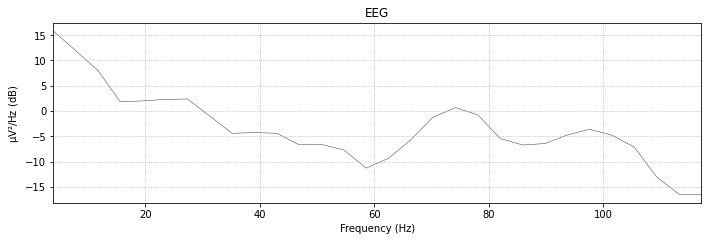

In [28]:
x.plot()

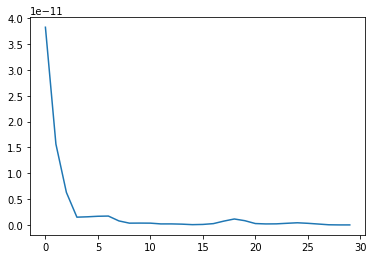

In [29]:
plt.plot(x.get_data()[0])

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)


C:\Users\user\AppData\Local\Temp/ipykernel_2340/1018545699.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw2.plot_psd(fmin=70, fmax=130)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


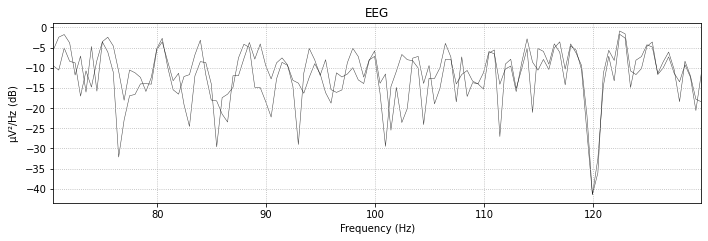

In [48]:
raw2 = raw.copy().crop(tmin=44, tmax=46)
raw2.plot_psd(fmin=70, fmax=130)


Effective window size : 0.256 (s)


C:\Users\user\AppData\Local\Temp/ipykernel_2340/1332143451.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw2.compute_psd(fmin=70, fmax=130).plot()
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


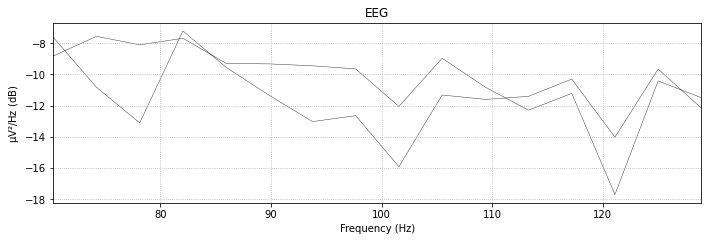

In [46]:
raw2.compute_psd(fmin=70, fmax=130).plot()

In [41]:
raw2.compute_psd(fmin=70, fmax=130).get_data()

Effective window size : 0.256 (s)


array([[4.50310441e-13, 4.34893504e-13, 2.04109464e-13, 1.57188594e-13,
        2.82274143e-13, 3.53506305e-13, 2.93835584e-13, 1.36342428e-13,
        2.55001776e-13, 3.54132551e-13, 1.94319834e-13, 1.09335336e-13,
        9.25238703e-14, 1.00654387e-13, 1.72447084e-13, 4.66068942e-14],
       [4.50035464e-13, 4.85028728e-13, 2.33116132e-13, 1.47711444e-13,
        2.62752372e-13, 2.89576735e-13, 2.83626724e-13, 1.41918379e-13,
        2.80213806e-13, 3.57633481e-13, 1.94160175e-13, 9.02674238e-14,
        7.34324287e-14, 1.24209982e-13, 1.86070154e-13, 4.83289979e-14]])

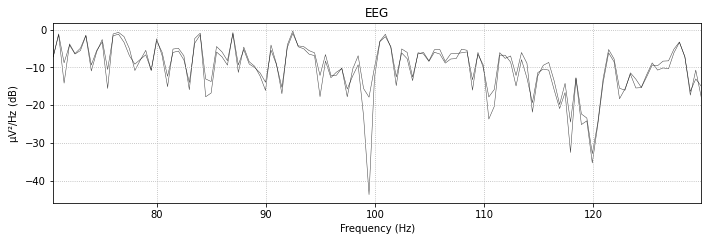

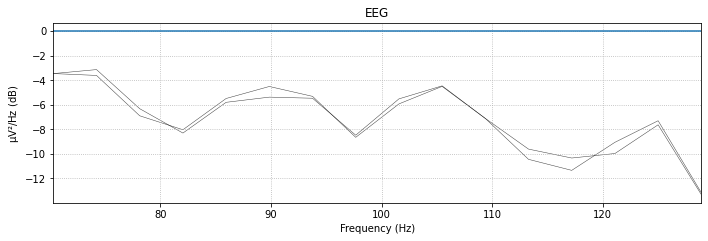

In [42]:
f, Pxx_den = signal.welch(raw2.get_data()[0], 1000, nperseg=256)
plt.plot(f, Pxx_den)
plt.show()